In [1]:
import json
import numpy as np
import pandas as pd
import tyssue

from tyssue import config, Sheet, PlanarGeometry, History, SheetGeometry
from tyssue.io import hdf5
from tyssue.utils.utils import _to_3d, _to_2d
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline



from tyssue.dynamics import units, effectors
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.quasistatic import QSSolver

collision solver could not be imported You may need to install CGAL and re-install tyssue


In [2]:
def to_nd(df, ndim):
    """
    Give a new shape to an input data by duplicating its column.

    Parameters
    ----------

    df : input data that will be reshape
    ndim : dimension of the new reshape data.

    Returns
    -------

    df_nd : return array reshaped in ndim.

    """
    df_nd = np.asarray(df).repeat(ndim).reshape((df.size, ndim))
    return df_nd

In [3]:
 def set_boundary_rectangle(nx, ny): #make sure distx and disty are 1
    x_min = 0.5 #always the lowest x coordinate for regular, trimmed, rectangular sheet
    y_min = 0.625 #always the lowest y coordinate for regular, trimmed, rectangular sheet
    x_max = x_min + nx
    y_max = y_min + ny
    return x_min, x_max, y_min, y_max    

In [4]:
x_min, x_max, y_min, y_max = set_boundary_rectangle(10, 10)

In [5]:
specs =  {
    'vert': {
        'height': 1,
        'basal_shift': 0,
        'delta_rho': 0,
        'boundary_K': 1.0,
    },
    'face': {
        'contractility': 1.12,
        'prefered_area': 1,
        'area_elasticity': 1,
        'prefered perimeter': 3.81
    },
    'edge': {
        'line_tension': 0.1,
    },
    'settings': {
        'geometry': 'flat',
        'height_axis': 'z',
        'threshold_length': 1e-3,
        'x_min': x_min,
        'x_max': x_max,
        'y_min': y_min,
        'y_max': y_max,   
    }
}

In [6]:
sheet_2d = Sheet.planar_sheet_3d('planar', nx=11, ny=12, 
                                 distx=1, disty=1, noise = 0.1)
sheet_2d.sanitize(trim_borders=True)

PlanarGeometry.update_all(sheet_2d)
sheet_2d.update_specs(specs)
sheet_2d.update_specs(sheet_2d.specs)

C++ extension are not available for this version


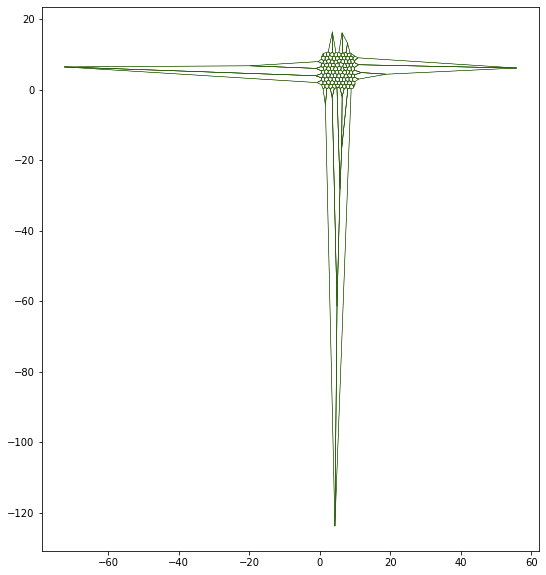

In [7]:
draw_specs = tyssue.config.draw.sheet_spec()

fig, (ax) = plt.subplots(1, figsize = (10, 10))
fig, ax = sheet_view(sheet_2d, ax=ax)

In [8]:
sheet_2d.get_extra_indices()

In [9]:
def get_border_vertices(eptm):
    border_vertex_coords = eptm.vert_df.iloc[eptm.edge_df.iloc[eptm.free_edges]["srce"].tolist()][eptm.coords]
    border_vertex_indices = eptm.vert_df.iloc[eptm.edge_df.iloc[eptm.free_edges]["srce"].tolist()][eptm.coords].index.values.tolist()
    eptm.vert_df['is_boundary'] = 0
    eptm.vert_df.loc[border_vertex_indices,['is_boundary']] = 1
    return border_vertex_indices, border_vertex_coords

In [10]:
border_vertex_indices, border_vertex_coords = get_border_vertices(sheet_2d)
border_vertex_indices, border_vertex_coords 

([8,
  14,
  35,
  34,
  59,
  155,
  162,
  46,
  161,
  6,
  60,
  57,
  149,
  215,
  2,
  219,
  220,
  233,
  179,
  234,
  11,
  56,
  18,
  201,
  9,
  157,
  209,
  83,
  217,
  5],
               x           y  z
 vert                          
 8      8.953523    0.324162  0
 14     2.455924   10.811543  0
 35     1.655393   -4.396895  0
 34     0.972394    0.329347  0
 59    -0.443404    8.012204  0
 155    4.638874   10.557972  0
 162    6.376046   16.186962  0
 46     5.080707   10.450096  0
 161    5.471628   10.632659  0
 6     10.082747    1.710551  0
 60     0.483655    8.659979  0
 57     0.531603    9.346541  0
 149   10.928504    9.090105  0
 215   -0.757926    2.062408  0
 2    -19.783380    6.824495  0
 219    8.635895   10.482611  0
 220    8.964449   10.307880  0
 233   11.082201    3.057407  0
 179    9.995684    2.310355  0
 234   18.914692    4.436277  0
 11     4.342511 -123.756424  0
 56     1.048314   10.359303  0
 18     1.949091   10.562191  0
 201    0.

In [11]:
def border_grad(eptm):
    
    gradient = pd.DataFrame(np.zeros((len(eptm.vert_df), len(eptm.coords))), columns = ['g' + c for c in eptm.coords], index = sheet_2d.vert_df.index)
    
    for i in eptm.vert_df.index.to_list():    
        if float(eptm.vert_df.loc[i, ['x']]) < eptm.settings.get('x_min'):
            gradient.loc[i, ['gx']] =  1
        if float(eptm.vert_df.loc[i, ['x']]) > eptm.settings.get('x_max'):
            gradient.loc[i, ['gx']] =  -1
        if float(eptm.vert_df.loc[i, ['y']]) < eptm.settings.get('y_min'):
            gradient.loc[i, ['gy']] =  1
        if float(eptm.vert_df.loc[i, ['y']]) > eptm.settings.get('y_max'):
            gradient.loc[i, ['gy']] =  -1
    return gradient 

In [12]:
class FlatRectangleBarrier(effectors.AbstractEffector):
    
    """
    Rectangular Barrier for 2D sheet objects
    """
    
    dimensions = units.line_elasticity
    magnitude = 'boundary_K'
    label = 'Flat rectangular boundary elasticity'
    element = 'vert'
    specs = {
        'vert': {
            'boundary_K': 1.0,
            'is_boundary': 1.0,
            'delta_rho': 1.0}
    }  # distance to the boundary

    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval(
            'delta_rho**2 * boundary_K/2')

    @staticmethod
    def gradient(eptm):
        grad = pd.DataFrame(to_nd(eptm.vert_df.eval('boundary_K * delta_rho'), len(eptm.coords)), columns = ['g' + c for c in eptm.coords], index = eptm.vert_df.index)
        grad = grad.mul(border_grad(eptm))
#         grad.columns = ['g' + c for c in eptm.coords]
        return grad, None

In [13]:
class BoundedRectangleSheetGeometry(SheetGeometry):
    
    @classmethod
    def update_all(cls, eptm):
        super().update_all(eptm)
        cls.update_delta_rho(eptm)
    
    @staticmethod
    def update_delta_rho(eptm):
        eptm.vert_df["delta_rhox"] = 0
        eptm.vert_df["delta_rhoy"] = 0
        for i in eptm.vert_df.index.to_list():    
            if float(eptm.vert_df.loc[i, ['x']]) < eptm.settings.get('x_min'):
                eptm.vert_df.loc[i, ['delta_rhox']] = float(eptm.settings.get('x_min')) - float(eptm.vert_df.loc[i, ['x']])
            if float(eptm.vert_df.loc[i, ['x']]) > eptm.settings.get('x_max'):
                eptm.vert_df.loc[i, ['delta_rhox']] = float(eptm.vert_df.loc[i, ['x']]) - float(eptm.settings.get('x_max'))
            if float(eptm.vert_df.loc[i, ['y']]) < eptm.settings.get('y_min'):
                eptm.vert_df.loc[i, ['delta_rhoy']] = float(eptm.settings.get('y_min')) - float(eptm.vert_df.loc[i, ['y']])
            if float(eptm.vert_df.loc[i, ['y']]) > eptm.settings.get('y_max'):
                eptm.vert_df.loc[i, ['delta_rhoy']] = float(eptm.vert_df.loc[i, ['y']]) - float(eptm.settings.get('y_max'))
        eptm.vert_df['delta_rho'] = eptm.vert_df.eval("(delta_rhox ** 2 + delta_rhoy ** 2) ** 0.5")
    

In [14]:
BoundedRectangleSheetGeometry.update_all(sheet_2d)

In [15]:
sheet_2d.vert_df

,y,is_active,x,z,rho,height,basal_shift,delta_rho,boundary_K,is_boundary,delta_rhox,delta_rhoy
vert,,,,,,,,,,,,
0,6.383208,1,9.919821,0,0,-4.0,4.0,0.000000,1.0,0,0.000000,0.0
1,4.371148,1,4.952499,0,0,-4.0,4.0,0.000000,1.0,0,0.000000,0.0
2,6.824495,1,-19.783380,0,0,-4.0,4.0,20.283380,1.0,1,20.283380,0.0
3,6.091969,1,-1.002525,0,0,-4.0,4.0,1.502525,1.0,0,1.502525,0.0
4,7.121389,1,11.062307,0,0,-4.0,4.0,0.562307,1.0,0,0.562307,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
231,3.571074,1,9.897744,0,0,-4.0,4.0,0.000000,1.0,0,0.000000,0.0
232,4.273949,1,9.905063,0,0,-4.0,4.0,0.000000,1.0,0,0.000000,0.0
233,3.057407,1,11.082201,0,0,-4.0,4.0,0.582201,1.0,1,0.582201,0.0


In [16]:
sheet_2d.edge_df["is_active"] = 1
sheet_2d.settings['threshold_length'] = 1e-3
sheet_2d.face_df["prefered_area"] = 1
sheet_2d.face_df["prefered_perimeter"] = 3.464
sheet_2d.face_df["perimeter_elasticity"] = 0.9
sheet_2d.edge_df["line_tension"]=0.24
sheet_2d.vert_df["barrier_elasticity"]=0.24

In [17]:
model = model_factory(
    [FlatRectangleBarrier],
    effectors.FaceAreaElasticity,
)

In [18]:
solver = QSSolver(with_collisions=False, with_t1=True, with_t3=True)

In [19]:
min_settings = {
#    "minimize":{
        'options': {
            'disp': False,
            'ftol': 1e-8,
            'gtol': 1e-8},
#    }
}
res = solver.find_energy_min(sheet_2d, BoundedRectangleSheetGeometry, model, periodic=False, **min_settings)

In [20]:
print(pd.__file__)

C:\Users\tasni\anaconda3\lib\site-packages\pandas\__init__.py


In [21]:
sheet_2d.vert_df.index.to_list()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [22]:
sheet_2d.settings.get('x_min')

0.5

In [23]:
sheet_2d.coords

['x', 'y', 'z']

In [24]:
pd.DataFrame(np.zeros((len(sheet_2d.vert_df), len(sheet_2d.coords))), columns = sheet_2d.coords)

,x,y,z
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
231,0.0,0.0,0.0
232,0.0,0.0,0.0
233,0.0,0.0,0.0
234,0.0,0.0,0.0


In [25]:
len(sheet_2d.vert_df)

236

In [26]:
sheet_2d.vert_df

,y,is_active,x,z,rho,height,basal_shift,delta_rho,boundary_K,is_boundary,delta_rhox,delta_rhoy,barrier_elasticity
vert,,,,,,,,,,,,,
0,6.383208,1,9.919821,0.0,0.0,-4.0,4.0,0.000000,1.0,0,0.000000,0.0,0.24
1,4.371148,1,4.952499,0.0,0.0,-4.0,4.0,0.000000,1.0,0,0.000000,0.0,0.24
2,6.824495,1,-19.783380,0.0,0.0,-4.0,4.0,20.283380,1.0,1,20.283380,0.0,0.24
3,6.091969,1,-1.002525,0.0,0.0,-4.0,4.0,1.502525,1.0,0,1.502525,0.0,0.24
4,7.121389,1,11.062307,0.0,0.0,-4.0,4.0,0.562307,1.0,0,0.562307,0.0,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,3.571074,1,9.897744,0.0,0.0,-4.0,4.0,0.000000,1.0,0,0.000000,0.0,0.24
232,4.273949,1,9.905063,0.0,0.0,-4.0,4.0,0.000000,1.0,0,0.000000,0.0,0.24
233,3.057407,1,11.082201,0.0,0.0,-4.0,4.0,0.582201,1.0,1,0.582201,0.0,0.24


In [27]:
to_nd(sheet_2d.vert_df.eval('boundary_K * delta_rho * is_boundary'), len(sheet_2d.coords))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.02833803e+01, 2.02833803e+01, 2.02833803e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.54018462e+01, 4.54018462e+01, 4.54018462e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.00837869e-01, 3.00837869e-01, 3.00837869e-01],
       [9.73153265e-02, 9.73153265e-02, 9.73153265e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.24381424e+02, 1.24381424e+02, 1.24381424e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.86542887e-01, 1.86542887e-01, 1.86542887e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000

In [28]:
border_grad(sheet_2d)

,gx,gy,gz
vert,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,-1.0,0.0,0.0
...,...,...,...
231,0.0,0.0,0.0
232,0.0,0.0,0.0
233,-1.0,0.0,0.0


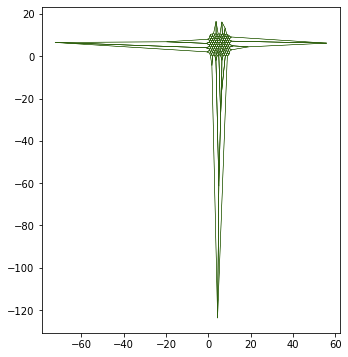

In [29]:
draw_specs = tyssue.config.draw.sheet_spec()

fig, (ax) = plt.subplots(1, figsize = (6, 6))
fig, ax = sheet_view(sheet_2d, ax=ax)

In [30]:
#ALL CODE BELO IS FOR TESTS 

In [31]:
type(FlatRectangleBarrier.gradient(sheet_2d))

tuple

In [32]:
srce, trgt = effectors.LineTension.gradient(sheet_2d)

In [33]:
print(sheet_2d.specs)

{'face': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'num_sides': 6, 'area': 1.0, 'perimeter': 1.0, 'is_alive': 1, 'contractility': 1.12, 'prefered_area': 1, 'area_elasticity': 1, 'prefered perimeter': 3.81}, 'vert': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'is_active': 1, 'rho': 0.0, 'height': 1, 'basal_shift': 0, 'delta_rho': 0, 'boundary_K': 1.0}, 'edge': {'srce': 0, 'trgt': 0, 'face': 0, 'dx': 0.0, 'dy': 0.0, 'dz': 0.0, 'nx': 0.0, 'ny': 0.0, 'nz': 0.0, 'sx': 0.0, 'sy': 0.0, 'sz': 0.0, 'tx': 0.0, 'ty': 0.0, 'tz': 0.0, 'fx': 0.0, 'fy': 0.0, 'fz': 0.0, 'length': 1.0, 'is_active': 1, 'ux': 0.0, 'uy': 0.0, 'uz': 0.0, 'line_tension': 0.1}, 'settings': {'geometry': 'flat', 'height_axis': 'z', 'threshold_length': 0.001, 'x_min': 0.5, 'x_max': 10.5, 'y_min': 0.625, 'y_max': 10.625}}


In [34]:
srce.index

RangeIndex(start=0, stop=678, step=1, name='edge')

In [35]:
#check gradient format
FlatRectangleBarrier.gradient(sheet_2d)

(             gx   gy   gz
 vert                     
 0      0.000000  0.0  0.0
 1      0.000000  0.0  0.0
 2     20.283380  0.0  0.0
 3      1.502525  0.0  0.0
 4     -0.562307  0.0  0.0
 ...         ...  ...  ...
 231    0.000000  0.0  0.0
 232    0.000000  0.0  0.0
 233   -0.582201  0.0  0.0
 234   -8.414692  0.0  0.0
 235   -1.338384  0.0  0.0
 
 [236 rows x 3 columns],
 None)

In [36]:
gradx = pd.DataFrame(to_nd(sheet_2d.vert_df.eval('boundary_K * delta_rho * is_boundary'), len(sheet_2d.coords)), columns = ['g' + c for c in sheet_2d.coords], index = sheet_2d.vert_df.index)

In [37]:
gradx.mul(border_grad(sheet_2d))

,gx,gy,gz
vert,,,
0,0.000000,0.0,0.0
1,0.000000,0.0,0.0
2,20.283380,0.0,0.0
3,0.000000,0.0,0.0
4,-0.000000,0.0,0.0
...,...,...,...
231,0.000000,0.0,0.0
232,0.000000,0.0,0.0
233,-0.582201,0.0,0.0


In [38]:
effectors.LineTension.gradient(sheet_2d)

(            gx        gy   gz
 edge                         
 0    -0.114399 -0.036235 -0.0
 1     0.093936  0.074673 -0.0
 2    -0.093936 -0.074673 -0.0
 3    -0.013319  0.119259 -0.0
 4     0.013319 -0.119259 -0.0
 ...        ...       ...  ...
 673   0.024385  0.117496 -0.0
 674   0.098279 -0.068856 -0.0
 675   0.056102 -0.106078 -0.0
 676  -0.119770  0.007420 -0.0
 677   0.119751 -0.007723 -0.0
 
 [678 rows x 3 columns],
             gx        gy   gz
 edge                         
 0     0.114399  0.036235  0.0
 1    -0.093936 -0.074673  0.0
 2     0.093936  0.074673  0.0
 3     0.013319 -0.119259  0.0
 4    -0.013319  0.119259  0.0
 ...        ...       ...  ...
 673  -0.024385 -0.117496  0.0
 674  -0.098279  0.068856  0.0
 675  -0.056102  0.106078  0.0
 676   0.119770 -0.007420  0.0
 677  -0.119751  0.007723  0.0
 
 [678 rows x 3 columns])

In [39]:
FlatRectangleBarrier.gradient(sheet_2d)[0].shape[0]

236

In [40]:
sheet_2d.Nv

236

In [41]:
vert_grads = FlatRectangleBarrier.gradient(sheet_2d)

In [42]:
model.compute_gradient(sheet_2d)

,gx,gy,gz
vert,,,
0,0.000000,0.0,0.0
1,0.000000,0.0,0.0
2,20.283380,0.0,0.0
3,1.502525,0.0,0.0
4,-0.562307,0.0,0.0
...,...,...,...
231,0.000000,0.0,0.0
232,0.000000,0.0,0.0
233,-0.582201,0.0,0.0


In [43]:
effectors.BarrierElasticity.gradient(sheet_2d)

(       gx   gy        gz
 vert                    
 0     0.0  0.0  0.000000
 1     0.0  0.0  0.000000
 2     0.0  0.0  4.868011
 3     0.0  0.0  0.360606
 4     0.0  0.0  0.134954
 ...   ...  ...       ...
 231   0.0  0.0  0.000000
 232   0.0  0.0  0.000000
 233   0.0  0.0  0.139728
 234   0.0  0.0  2.019526
 235   0.0  0.0  0.321212
 
 [236 rows x 3 columns],
 None)

In [44]:
effectors.BarrierElasticity.energy(sheet_2d)

vert
0       0.000000
1       0.000000
2      49.369862
3       0.270910
4       0.037943
         ...    
231     0.000000
232     0.000000
233     0.040675
234     8.496844
235     0.214953
Length: 236, dtype: float64

In [45]:
#LineTension effector for comparison
effectors.LineTension.energy(sheet_2d)

edge
0      0.080882
1      0.087122
2      0.087122
3      0.088276
4      0.088276
         ...   
673    0.689456
674    0.159705
675    0.395212
676    8.620160
677    5.408013
Length: 678, dtype: float64

In [46]:
vert_grads

(             gx   gy   gz
 vert                     
 0      0.000000  0.0  0.0
 1      0.000000  0.0  0.0
 2     20.283380  0.0  0.0
 3      1.502525  0.0  0.0
 4     -0.562307  0.0  0.0
 ...         ...  ...  ...
 231    0.000000  0.0  0.0
 232    0.000000  0.0  0.0
 233   -0.582201  0.0  0.0
 234   -8.414692  0.0  0.0
 235   -1.338384  0.0  0.0
 
 [236 rows x 3 columns],
 None)

In [47]:
FlatRectangleBarrier.energy(sheet_2d)

vert
0        0.000000
1        0.000000
2      205.707758
3        1.128790
4        0.158095
          ...    
231      0.000000
232      0.000000
233      0.169479
234     35.403517
235      0.895636
Length: 236, dtype: float64

In [48]:
# May need to convert gradient and energy to a edge-based dataframe? 

In [49]:
sheet_2d.face_df

,y,is_alive,perimeter,area,x,num_sides,z,contractility,prefered_area,area_elasticity,prefered perimeter,height,rho,vol,prefered_perimeter,perimeter_elasticity
face,,,,,,,,,,,,,,,,
0,-0.755271,1,10.806426,2.717602,1.556213,4,0.0,1.12,1,1,3.81,-4.0,0.0,-10.870408,3.464,0.9
1,-27.199645,1,249.490123,182.937399,3.172089,7,0.0,1.12,1,1,3.81,-4.0,0.0,-731.749595,3.464,0.9
2,-0.168553,1,6.543691,1.617633,3.624710,4,0.0,1.12,1,1,3.81,-4.0,0.0,-6.470533,3.464,0.9
3,-15.020797,1,124.719560,69.644499,4.689600,6,0.0,1.12,1,1,3.81,-4.0,0.0,-278.577994,3.464,0.9
4,-7.551286,1,58.169463,23.715686,5.774267,6,0.0,1.12,1,1,3.81,-4.0,0.0,-94.862745,3.464,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,12.045028,1,13.002533,3.663934,3.167779,4,0.0,1.12,1,1,3.81,-4.0,0.0,-14.655736,3.464,0.9
115,11.975486,1,12.946778,3.070965,4.001502,4,0.0,1.12,1,1,3.81,-4.0,0.0,-12.283861,3.464,0.9
116,11.898902,1,12.570862,3.291836,6.132835,4,0.0,1.12,1,1,3.81,-4.0,0.0,-13.167343,3.464,0.9
